In [1]:
import cooler
import numpy as np
import tensorflow as tf
from iced import normalization

import matplotlib.pyplot as plt
from IPython import display
import time
tf.keras.backend.set_floatx('float64')

(2432, 2432)
(573, 573)


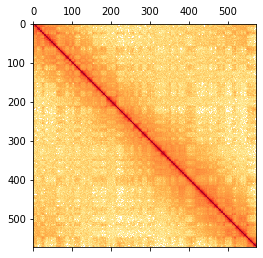

In [2]:
# data from ftp://cooler.csail.mit.edu/coolers/hg19/
name = 'Dixon2012-H1hESC-HindIII-allreps-filtered.100kb.cool'
#name = 'Rao2014-K562-MboI-allreps-filtered.500kb.cool'
c = cooler.Cooler(name)
resolution = c.binsize
mat= c.matrix(balance=True).fetch('chr2')
print(mat.shape)
idxy = ~np.all(np.isnan(mat),axis=0)
M = mat[idxy,:]
Mh = M[:,idxy]

IMG_HEIGHT, IMG_WIDTH = int(Mh.shape[0]/4),int(Mh.shape[1]/4)
img_l = np.zeros(shape=(IMG_HEIGHT, IMG_WIDTH))
for i in list(range(0, len(Mh))):
    x = int(np.floor(i/(len(Mh)/IMG_HEIGHT)))
    for j in list(range(0,len(Mh))):
        y = int(np.floor(j/(len(Mh)/IMG_WIDTH)))
        img_l[x, y] = img_l[x, y] + Mh[i,j]

Ml = img_l
plt.matshow(np.log2(Ml), cmap='YlOrRd')
print(Ml.shape)

[[0.89393597 0.41144374 0.11668454 ... 0.00229435 0.00277445 0.01112722]
 [0.41143156 0.78016353 0.40573059 ... 0.00171394 0.00338166 0.00503872]
 [0.11667805 0.40572002 0.79841626 ... 0.00139255 0.00265129 0.00401371]
 ...
 [0.00240343 0.00179548 0.00145884 ... 0.88379032 0.29250773 0.14181561]
 [0.0029061  0.00354223 0.00277725 ... 0.2924824  0.8881726  0.34081257]
 [0.01165404 0.00527744 0.00420398 ... 0.14178918 0.34077856 0.92428552]]


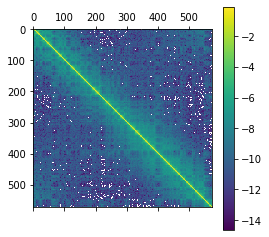

In [58]:
import copy
Ml = img_l
#print('original Ml: ', Ml)
#Ml = normalization.ICE_normalization(Ml)
Ml = normalization.SCN_normalization(Ml)
#print(Ml.sum(0))
print(Ml)
plt.matshow(np.log2(Ml))
plt.colorbar()

128 128


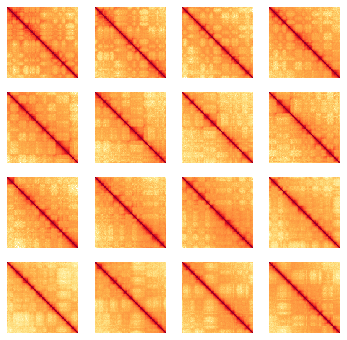

In [4]:
hic_lr = []
IMG_HEIGHT, IMG_WIDTH = int(512/4),int(512/4)
print(IMG_HEIGHT, IMG_WIDTH)
for i in range(len(Ml)-IMG_HEIGHT+1):
    hic_lr.append(Ml[i:i+IMG_HEIGHT, i:i+IMG_WIDTH])
hic_lr = np.array(hic_lr)
hic_lr_ds = tf.convert_to_tensor(hic_lr)
fig = plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.log2(hic_lr[i*25,:,:]), cmap='YlOrRd')
    plt.axis('off')

In [5]:
class GraphConvLayer(tf.keras.layers.Layer):
    def __init__(self, units, name='GCL'):
        super(GraphConvLayer, self).__init__(name=name)
        self.num_outputs = units

    def build(self, input_shape, ):
        init_w = tf.random_normal_initializer(mean=0, stddev=0.1)
        self.w = tf.Variable(initial_value=init_w(shape=(input_shape[1][2], self.num_outputs), dtype=tf.float64), trainable=True)
    
    # ReLU(AXW)
    def call(self, input):
        A = input[0]
        X = input[1]
        A = tf.expand_dims(A, -1)
        A = tf.expand_dims(A, -1)
        X = tf.expand_dims(X, -4)
        AX = tf.multiply(A, X)
        AX = tf.reduce_sum(AX, axis=2)
        #AX = tf.transpose(AX, perm=[1,0,2,3])
        AXW = tf.tensordot(AX, self.w, axes = [[2], [0]])
        AXW = tf.transpose(AXW, perm=[0,1,3,2])

        return AXW


In [6]:
def make_discriminator_model():
    InA = tf.keras.layers.Input(shape=(128, 128), name='InA', dtype=tf.float64)
    InX = tf.keras.layers.Input(shape=(128, 255, 1), name='InX', dtype=tf.float64)
    Trans0 = tf.keras.layers.Conv2D(12, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Trans0')(InX)
    GCL1 = GraphConvLayer(32, name='GCL1')([InA, Trans0])
    Relu1 = tf.keras.layers.ReLU(name='relu1')(GCL1)
    Trans1 = tf.keras.layers.Conv2D(12, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Trans1')(Relu1)
    GCL2 = GraphConvLayer(1, name='GCL2')([InA, Trans1])
    Relu2 = tf.keras.layers.ReLU(name='relu2')(GCL2)
    Trans2 = tf.keras.layers.Conv2D(12, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Trans2')(Relu2)
    Flat = tf.keras.layers.Flatten()(Trans2)
    Out = tf.keras.layers.Dense(1, activation='relu', use_bias=False)(Flat)
    model = tf.keras.models.Model(inputs=[InA, InX], outputs=[Out])
    return model
    

In [41]:
class Rank1Reconstruct(tf.keras.layers.Layer):
    def __init__(self, filters, name='RR'):
        super(Rank1Reconstruct, self).__init__(name=name)
        self.num_outputs = filters
        w_init = tf.ones_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(1,1,1,filters), dtype='float64'))
        
    def build(self, input_shape):
        pass
        
    def call(self, input):
        v = tf.math.add(input, tf.constant(1e-6, dtype=tf.float64))
        vt = tf.transpose(v, perm=[0,2,1,3])
        rank1m = tf.multiply(tf.multiply(v, vt), self.w)
        return rank1m

class DiagonalWeight(tf.keras.layers.Layer):
    def __init__(self, input_dim, name='DW'):
        super(DiagonalWeight, self).__init__(name=name)
        #w_init = tf.random_normal_initializer()
        w_init = tf.ones_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(1, input_dim), dtype='float64'), trainable=True)

    def call(self, inputs):
        self.w.assign(tf.clip_by_value(self.w, 0.0, 1.0))
        #self.w.assign(tf.math.minimum(1.0, self.w))
        opw = tf.linalg.LinearOperatorToeplitz(self.w, self.w)

        return tf.multiply(inputs, 
            tf.expand_dims(opw.to_dense(),-1))
class Normal(tf.keras.layers.Layer):
    def __init__(self, input_dim, name='DW'):
        super(Normal, self).__init__(name=name)
        w_init = tf.ones_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(1, input_dim, 1, 1), dtype='float64'), trainable=True)
        d_init = tf.zeros_initializer()
        self.d = tf.Variable(initial_value=d_init(shape=(1, input_dim), dtype='float64'), trainable=True)

    def call(self, inputs):
        rowsr = tf.math.sqrt(tf.math.reduce_sum(tf.multiply(inputs, inputs), axis=1, keepdims=True))
        colsr = tf.math.sqrt(tf.math.reduce_sum(tf.multiply(inputs, inputs), axis=2, keepdims=True))
        sumele = tf.math.multiply(rowsr, colsr)
        #tf.math.divide_no_nan(inputs, sumele)
        Div = tf.math.divide_no_nan(inputs, sumele)
        self.w.assign(tf.nn.relu(self.w))
        self.d.assign(tf.nn.relu(self.d))
        WT = tf.transpose(self.w, perm=[0,2,1,3])
        M = tf.multiply(self.w, WT)
        opd = tf.linalg.LinearOperatorToeplitz(self.d, self.d)
        opd = tf.expand_dims(opd.to_dense(), axis=-1)
        return tf.add(tf.multiply(Div, M), opd)

In [42]:
def make_generator_model():
    In = tf.keras.layers.Input(shape=(128, 128, 1), name='In', dtype=tf.float64)

    Dec1 = tf.keras.layers.Conv2D(256, [1, 128], strides=1, padding='valid', data_format="channels_last", activation='relu', use_bias=False, kernel_constraint=tf.keras.constraints.NonNeg(),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.01, stddev=0.1),  name='Dec1')(In) 
    Drop1 = tf.keras.layers.Dropout(0.5)(Dec1)
    Rec1 = Rank1Reconstruct(256, name='Rec1')(Dec1)
    Sum1 = tf.keras.layers.Conv2D(1, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=10.0), kernel_constraint=tf.keras.constraints.NonNeg(), name='Sum1')(Rec1)

    '''Residual2 = tf.keras.layers.Subtract(name='Sub2')([In, Sum1])
    ReLU2 = tf.keras.layers.ReLU(name='relu2')(Residual2)

    Dec2 = tf.keras.layers.Conv2D(64, [128, 1], strides=1, padding='valid', data_format="channels_last", activation='relu', use_bias=False, kernel_constraint=tf.keras.constraints.NonNeg(),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.01, stddev=0.1),  name='Dec2')(ReLU2) 
    Drop2 = tf.keras.layers.Dropout(0.5)(Dec2)
    Rec2 = Rank1Reconstruct(64, name='Rec2')(Drop2)
    Sum2= tf.keras.layers.Conv2D(1, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0, seed=None), kernel_constraint=tf.keras.constraints.NonNeg(), name='Sum2')(Rec2)

    Residual3 = tf.keras.layers.Subtract(name='Sub3')([ReLU2, Sum2])
    ReLU3 = tf.keras.layers.ReLU(name='relu3')(Residual3)

    Dec3 = tf.keras.layers.Conv2D(32, [128, 1], strides=1, padding='valid', data_format="channels_last", activation='relu', use_bias=False, kernel_constraint=tf.keras.constraints.NonNeg(),kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.01, stddev=0.1),  name='Dec3')(ReLU3) 
    Drop3 = tf.keras.layers.Dropout(0.5)(Dec3)
    Rec3 = Rank1Reconstruct(32, name='Rec3')(Drop3)
    Sum3= tf.keras.layers.Conv2D(1, [1,1], use_bias=False, kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1.0, seed=None), kernel_constraint=tf.keras.constraints.NonNeg(), name='Sum3')(Rec3)'''

    #comb = tf.keras.layers.Add(name='Combine')([Sum1, Sum2, Sum3])
    #dw = DiagonalWeight(128, name='DW')(comb)
    out = Normal(128, name='Out')(Sum1)

    model = tf.keras.models.Model(inputs=[In],outputs=[out])
    return model

Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
In (InputLayer)              [(None, 128, 128, 1)]     0         
_________________________________________________________________
Dec1 (Conv2D)                (None, 128, 1, 256)       32768     
_________________________________________________________________
Rec1 (Rank1Reconstruct)      (None, 128, 128, 256)     256       
_________________________________________________________________
Sum1 (Conv2D)                (None, 128, 128, 1)       256       
_________________________________________________________________
Out (Normal)                 (None, 128, 128, 1)       256       
Total params: 33,536
Trainable params: 33,536
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_69"
_________________________________________________________________________________________________

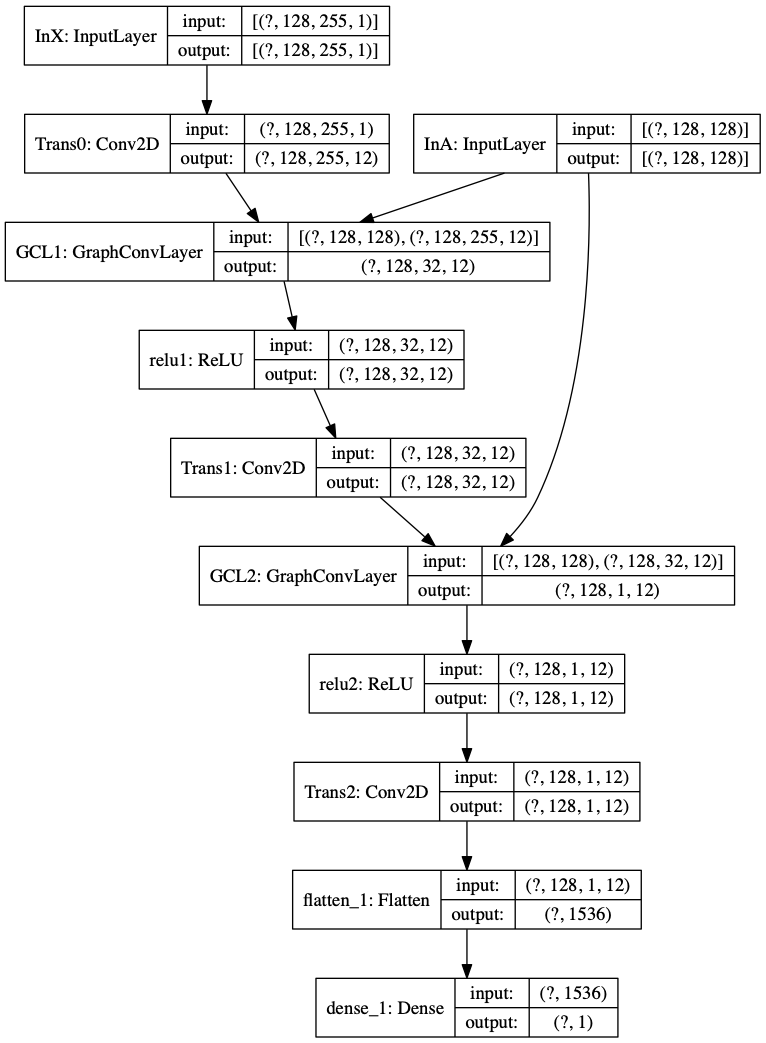

In [43]:
Gen = make_generator_model()
Dis = make_discriminator_model()
print(Gen.summary())
tf.keras.utils.plot_model(Gen, to_file='G.png',show_shapes=True)
print(Dis.summary())
tf.keras.utils.plot_model(Dis, to_file='D.png', show_shapes=True)

In [44]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss_mean(y_pred, y_true):
    #return cross_entropy(tf.ones_like(fake_output), fake_output)
    #return tf.reduce_mean(tf.abs(y_pred - y_true))
    return tf.math.reduce_mean(
            tf.math.divide_no_nan(tf.abs(tf.subtract(y_true, y_pred)), y_true), 
            axis=[1,2,3])
def generator_loss_std(y_pred, y_true):
    #return cross_entropy(tf.ones_like(fake_output), fake_output)
    #return tf.reduce_mean(tf.abs(y_pred - y_true))
    return tf.math.reduce_std(
            tf.math.divide_no_nan(tf.subtract(y_true, y_pred), y_true), 
            axis=[1,2,3])

In [45]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adagrad()
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=Gen,
                                 discriminator=Dis)

In [46]:
@tf.function
def train_step(A, X, img, mFilter):
    with tf.GradientTape() as gen_tape_m, tf.GradientTape() as gen_tape_s, tf.GradientTape() as disc_tape:
        fake_hic = Gen(img, training=True)

        real_output = Dis([A, X], training=True)
        '''A_f = tf.squeeze(tf.cast(fake_hic>1e-2, dtype=tf.float64), axis=-1)

        mFilter = tf.expand_dims(mFilter, axis=0)
        X_f = tf.multiply(fake_hic, mFilter)
        X_f = tf.math.reduce_sum(X_f, axis= 2)
        X_f = tf.expand_dims(X_f, axis=-1)
        fake_output = Dis([A_f, X_f], training=True)'''

        gen_loss_m = generator_loss_mean(fake_hic, img)
        gen_loss_s = generator_loss_std(fake_hic, img)
        

        gradients_of_generator_m = gen_tape_m.gradient(gen_loss_m, Gen.trainable_variables)
        gradients_of_generator_s = gen_tape_s.gradient(gen_loss_s, Gen.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator_m, Gen.trainable_variables))
        generator_optimizer.apply_gradients(zip(gradients_of_generator_s, Gen.trainable_variables))
        
        #disc_loss = discriminator_loss(real_output, fake_output)
        #gradients_of_discriminator = disc_tape.gradient(disc_loss, Dis.trainable_variables)
        #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, Dis.trainable_variables))

In [47]:
def train(dataset, A, X, epochs, BATCH_SIZE, mFilter):
    #print(dataset)
    for epoch in range(epochs):
        start = time.time()
        for i, image_batch in enumerate(dataset.take(1)):
            A_batch = tf.convert_to_tensor(A[i:i+BATCH_SIZE,:,:], dtype=tf.float64)
            X_batch = tf.convert_to_tensor(X[i:i+BATCH_SIZE,:,:], dtype=tf.float64)
            train_step(A_batch, X_batch, image_batch, mFilter)

        # Save the model every 15 epochs
        if (epoch + 1) % 25 == 0:
            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(Gen, epoch + 1, None)
            checkpoint.save(file_prefix = checkpoint_prefix)
            print ('Time for epoch {} is {} sec.'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    #display.clear_output(wait=True)
    #generate_and_save_images(Gen, epochs, None)

In [48]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    test_input = np.ones(shape=[1,128,128,1])
    test_input[0,:,:,0] = hic_lr[0,:,:]
    predictions = tf.squeeze(model(test_input, training=False))
    #print('Pred: ', predictions)
    rows = 3
    cols = 3
    plt.figure(figsize=(9, 9), constrained_layout=True)
    plt.subplot(rows,cols,1)
    plt.imshow(np.log2(np.squeeze(hic_lr[0,:,:])))
    #plt.axis('off')
    plt.title('Original')
    plt.subplot(rows,cols,2)
    plt.imshow(np.log2(predictions))
    #plt.axis('off')
    plt.title('X Hat')
    plt.subplot(rows,cols,3)
    plt.imshow(np.log2(np.squeeze(hic_lr[0,:,:])-predictions), cmap='RdBu')
    #plt.axis('off')
    plt.title('Diff')

    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('Sum1').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,4)
    plt.imshow(np.log2(np.squeeze(intermediate_output)), cmap='RdBu')
    #plt.axis('off')
    plt.title('before WX+b')
    m = model.get_layer('Out').get_weights()
    plt.subplot(rows,cols,5)
    plt.plot(np.squeeze(m[0]))
    plt.title('W')
    plt.subplot(rows,cols,6)
    plt.plot(np.squeeze(m[1]))
    plt.title('bias')

    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('Dec1').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,7)
    plt.imshow(np.squeeze(intermediate_output))
    plt.axis('off')
    '''intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('Dec2').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,8)
    plt.imshow(np.squeeze(intermediate_output))
    plt.axis('off')
    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('Dec3').output )
    intermediate_output = intermediate_layer_model.predict(test_input)
    plt.subplot(rows,cols,9)
    plt.imshow(np.squeeze(intermediate_output))
    plt.axis('off')'''

    plt.savefig('./lvl2/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [49]:
EPOCHS = 800
BUFFER_SIZE = 1
BATCH_SIZE = 3
train_dataset = tf.data.Dataset.from_tensor_slices(hic_lr[..., np.newaxis]).batch(BATCH_SIZE)
A_lr = (hic_lr>1e-1).astype(dtype=float)
A_dataset = tf.data.Dataset.from_tensor_slices(A_lr).batch(BATCH_SIZE)
X_lr = np.zeros(shape=(A_lr.shape[0], A_lr.shape[1], 2*A_lr.shape[2]-1), dtype=float)
n = X_lr.shape[1]

for i in list(range(0, X_lr.shape[1])):
    X_lr[:,i,n-1-i:(n-1-i)+n] = A_lr[:, i, :]
X_dataset = tf.data.Dataset.from_tensor_slices(X_lr).batch(BATCH_SIZE)

mFilter = np.zeros(shape=(A_lr.shape[1], A_lr.shape[1], 2*A_lr.shape[2]-1))
for i in list(range(0, mFilter.shape[2])):
    mlen = i+1 if i<128 else 255-i
    mFilter[:,:,i] = np.diag(np.ones(shape=(mlen,)), k=i-(A_lr.shape[1]-1))
mFilter = tf.convert_to_tensor(mFilter, dtype=tf.float64)



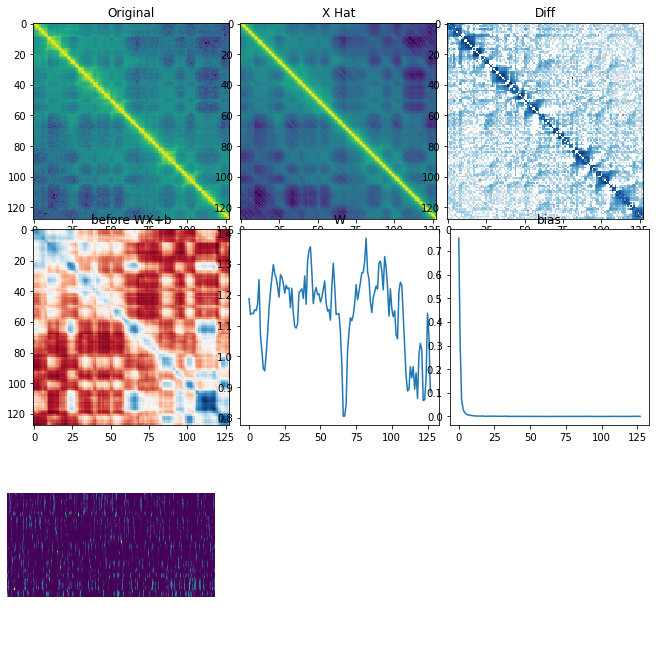

Time for epoch 800 is 6.504055976867676 sec.


In [50]:
train(train_dataset, A_lr, X_lr[..., np.newaxis], EPOCHS, BATCH_SIZE, mFilter)

T:  356.1012998614102
pred:  303.6669722739495
diff:  70.63667116483813


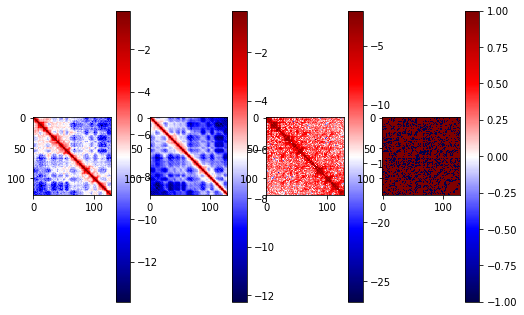

In [54]:
import iced
import copy
test_input = np.ones(shape=[1,128,128,1])
test_input[0,:,:,0] = copy.copy(hic_lr[0,:,:])
predictions = tf.squeeze(Gen(test_input, training=False))
hic_pred = predictions.numpy()
#hic_pred = normalization.SCN_normalization(hic_pred)
plt.figure(figsize=(8,24))
plt.subplot(1,4,1)
T = np.squeeze(test_input[0,:,:])
pct = np.percentile(T, 99.9)
T[T>pct] = pct
plt.imshow(np.log2(T), cmap='seismic')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(np.log2(hic_pred), cmap='seismic')
plt.colorbar()
plt.subplot(1,4,3)
diff = (T - hic_pred)
plt.imshow(np.log2(np.abs(diff)), cmap='seismic')
plt.colorbar()
plt.subplot(1,4,4)
diff[diff>0] = 1
diff[diff<0] = -1
plt.imshow((diff), cmap='seismic')
plt.colorbar()

print('T: ', np.sum(T))
print('pred: ', np.sum(hic_pred))
print('diff: ', np.sum(np.abs(T-hic_pred)))
#print(hic_pred)

Text(0.5, 1.0, 'Image with noise')

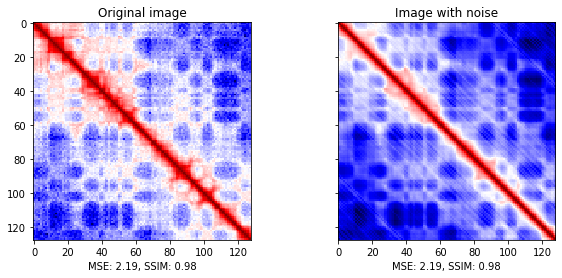

In [53]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
def mse(x, y):
    return np.linalg.norm(x - y)

T = np.squeeze(test_input[0,:,:])
pct = np.percentile(T, 100)
T[T>pct] = pct
mse_noise = mse(T, hic_pred)
ssim_noise = ssim(T, hic_pred, data_range=T.max() - T.min())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

label = 'MSE: {:.2f}, SSIM: {:.2f}'

ax[0].imshow(np.log2(T), cmap='seismic')
ax[0].set_xlabel(label.format(mse_noise, ssim_noise))
ax[0].set_title('Original image')

ax[1].imshow(np.log2(hic_pred), cmap='seismic')
ax[1].set_xlabel(label.format(mse_noise, ssim_noise))
ax[1].set_title('Image with noise')

In [ ]:
Gen.save('./saved_model/gen_model') 

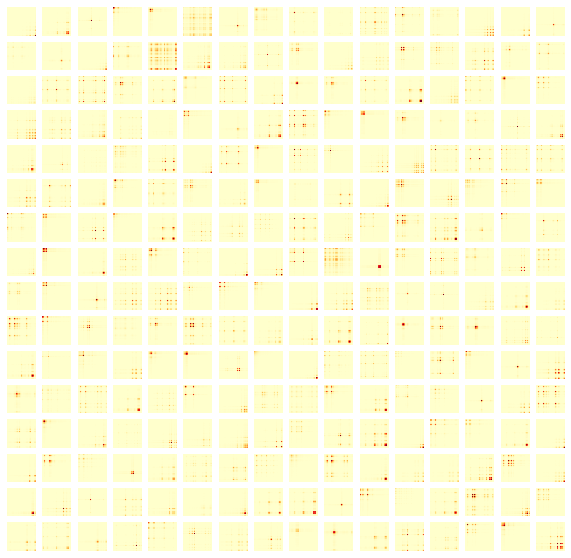

In [56]:
intermediate_layer_model = tf.keras.models.Model(inputs=Gen.input, outputs=Gen.get_layer('Rec1').output )
intermediate_output = intermediate_layer_model.predict(test_input)
#print(intermediate_output.shape)
step = 2
fig = plt.figure(figsize=(10, 10), constrained_layout=False)
for i in range(0,256):#,intermediate_output.shape[3],step):
    #print(i)
    plt.subplot(16, 16, i+1)
    plt.imshow((np.squeeze(intermediate_output[0, :, :, i])), cmap='YlOrRd')
    plt.axis('off')
plt.savefig('./lvl3/image_features.png')
plt.show()

In [57]:
import imageio
import glob
anim_file = 'gcn_2_losses.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./lvl2/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)